## Modules & Helpful Functions

In [1]:
!pip install --upgrade neural_structured_learning --user

     |████████████████████████████████| 104 kB 2.7 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np,pylab as pl,pandas as pd
import sys,h5py,urllib,zipfile
import tensorflow as tf
import neural_structured_learning as nsl
from sklearn import datasets
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
def display_10img(X,y,s):
    fig,ax=pl.subplots(figsize=(10,3),nrows=2,ncols=5,
                       sharex=True,sharey=True)
    ax=ax.flatten()
    for i in range(10):
        ax[i].imshow(X[i].reshape(s,s),cmap=pl.cm.Greens)
        ax[i].set_title(y[i])
    ax[0].set_xticks([]); ax[0].set_yticks([])
    pl.tight_layout()
def prepro(x_train,y_train,x_test,y_test,n_class):
    n=int(len(x_test)/2)    
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    cy_train=to_categorical(y_train,n_class) 
    cy_valid=to_categorical(y_valid,n_class)
    cy_test=to_categorical(y_test,n_class)
    df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                     [y_train.shape,y_valid.shape,y_test.shape],
                     [cy_train.shape,cy_valid.shape,cy_test.shape]],
                    columns=['train','valid','test'],
                    index=['images','labels','encoded labels'])
    display(df)
    return [[x_train,x_valid,x_test],
            [y_train,y_valid,y_test],
            [cy_train,cy_valid,cy_test]]

## Data
### #1

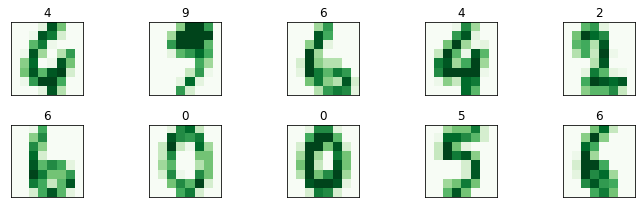

In [4]:
digits=datasets.load_digits(n_class=10)
X1,y1=digits.data,digits.target
X_train1,X_test1,y_train1,y_test1=\
train_test_split(X1,y1,test_size=.2,random_state=1)
display_10img(X_train1,y_train1,8)

### #2

11493376/11490434 [==============================] - 2s 0us/step


,train,valid,test
images,"(60000, 784)","(5000, 784)","(5000, 784)"
labels,"(60000,)","(5000,)","(5000,)"
encoded labels,"(60000, 10)","(5000, 10)","(5000, 10)"


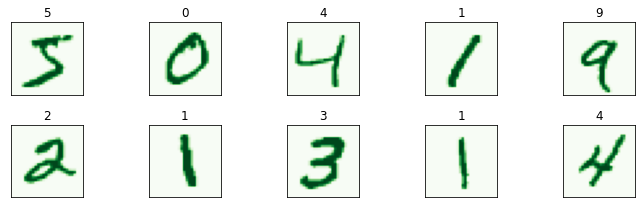

In [5]:
(X_train2,y_train2),(X_test2,y_test2)=mnist.load_data()
X_train2=X_train2.reshape(-1,784).astype('float32')
X_test2=X_test2.reshape(-1,784).astype('float32')
y_train2=y_train2.astype('int32')
y_test2=y_test2.astype('int32')
[[X_train2,X_valid2,X_test2],
 [y_train2,y_valid2,y_test2],
 [cy_train2,cy_valid2,cy_test2]]=\
prepro(X_train2,y_train2,X_test2,y_test2,10)
display_10img(X_train2,y_train2,28)

### #3

,train,valid,test
images,"(4752, 1024)","(594, 1024)","(594, 1024)"
labels,"(4752,)","(594,)","(594,)"
encoded labels,"(4752, 33)","(594, 33)","(594, 33)"


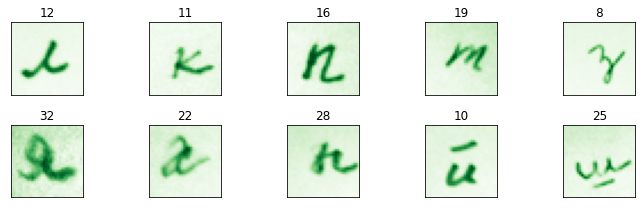

In [6]:
fpath='../input/classification-of-handwritten-letters/'
f=h5py.File(fpath+'LetterColorImages2.h5','r')
keys=list(f.keys()); rn=10**3
letters=u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
X3=np.array(f[keys[1]])/255
X3=1-np.dot(X3[...,:3],[.299,.587,.114])
y3=np.array(f[keys[2]])-1
X_train3,X_test3,y_train3,y_test3=\
train_test_split(X3,y3,test_size=.2,random_state=1)
X_train3=X_train3.reshape(-1,32*32).astype('float32')
X_test3=X_test3.reshape(-1,32*32).astype('float32')
y_train3=y_train3.astype('int32')
y_test3=y_test3.astype('int32')
[[X_train3,X_valid3,X_test3],
 [y_train3,y_valid3,y_test3],
 [cy_train3,cy_valid3,cy_test3]]=\
prepro(X_train3,y_train3,X_test3,y_test3,33)
display_10img(X_train3,y_train3,32)

## Neural Networks
### #1

In [7]:
def trainNN(X,y,D,K,h,a,r,step_size,epochs):
    W1=a*np.random.randn(D,h)
    b1=np.zeros((1,h))
    W2=a*np.random.randn(h,K)
    b2=np.zeros((1,K))
    # gradient descent loop
    num_examples=X.shape[0]
    for i in range(epochs): 
        # evaluate class scores
        hidden_layer=np.maximum(0,np.dot(X,W1)+b1) # ReLU activation
        scores=np.dot(hidden_layer,W2)+b2  
        # compute the class probabilities
        exp_scores=np.exp(scores)
        probs=exp_scores/np.sum(exp_scores,axis=1,keepdims=True)   
        # compute the loss: average cross-entropy loss and regularization
        corect_logprobs=-np.log(probs[range(num_examples),y])
        data_loss=np.sum(corect_logprobs)/num_examples
        reg_loss=.5*r*np.sum(W1**2)+.5*r*np.sum(W2**2)
        loss=data_loss+reg_loss
        if (i+1)%500==0:
            print("iteration %d: loss %f"%(i+1,loss))  
        # compute the gradient on scores
        dscores=probs
        dscores[range(num_examples),y]-=1
        dscores/=num_examples  
        # backpropate the gradient to the parameters
        # first backprop into parameters W2 and b2
        dW2=np.dot(hidden_layer.T,dscores)
        db2=np.sum(dscores,axis=0,keepdims=True)
        # next backprop into hidden layer
        dhidden=np.dot(dscores,W2.T)
        # backprop the ReLU non-linearity
        dhidden[hidden_layer<=0]=0
        # finally into W,b
        dW1=np.dot(X.T,dhidden)
        db1=np.sum(dhidden,axis=0,keepdims=True)  
        # add regularization gradient contribution
        dW2+=r*W2; dW1+=r*W1  
        # perform a parameter update
        W1+=-step_size1*dW1; b1+=-step_size1*db1
        W2+=-step_size1*dW2; b2+=-step_size1*db2
    return [W1,b1,W2,b2]
def predict(X,W1,b1,W2,b2):
    hidden_layer=np.maximum(0,np.dot(X,W1)+b1)
    scores=np.dot(hidden_layer,W2)+b2
    return np.argmax(scores,axis=1)
def accuracy(y,py): return np.mean(py==y)*100

In [8]:
D1=64 # dimensionality
K1=10 # number of classes
h1=320 # size of hidden layer
# hyperparameters
a1=1e-3; step_size1=1e-2; epochs1=2500
r1=1e-4 # regularization strength
[W11,b11,W12,b12]=\
trainNN(X_train1,y_train1,D1,K1,h1,
        a1,r1,step_size1,epochs1)

iteration 500: loss 0.168716
iteration 1000: loss 0.086499
iteration 1500: loss 0.058611
iteration 2000: loss 0.043109
iteration 2500: loss 0.033196


In [9]:
py_train1=predict(X_train1,W11,b11,W12,b12)
acc_train1=accuracy(y_train1,py_train1)
print('Digits. Train accuracy: %.2f'%acc_train1)
py_test1=predict(X_test1,W11,b11,W12,b12)
acc_test1=accuracy(y_test1,py_test1)
print('Digits. Test accuracy: %.2f'%acc_test1)

Digits. Train accuracy: 99.72
Digits. Test accuracy: 96.67


### #2

In [10]:
lr=.001; epochs=12; hidden1=256; hidden2=256
batch_size=128; display_step=1; 
n_inputs=784; n_classes=10

In [11]:
def cat_accuracy(predictions,labels):
    return (100.0*np.sum(np.argmax(predictions,1)==\
           np.argmax(labels,1))/predictions.shape[0])
def mlp(x):
    layer1=tf.add(tf.matmul(x,weights['W1']),biases['b1'])
    layer2=tf.add(tf.matmul(layer1,weights['W2']),biases['b2'])
    return tf.matmul(layer2,weights['out'])+biases['out']
graph=tf.Graph()
with graph.as_default():
    X=tf.compat.v1.placeholder("float32",[None,n_inputs])
    y=tf.compat.v1.placeholder("int32",[None,n_classes])
    vX=tf.constant(X_test2)
    weights={'W1':tf.Variable(\
                  tf.compat.v1.random_normal([n_inputs,hidden1])),
             'W2':tf.Variable(\
                  tf.compat.v1.random_normal([hidden1,hidden2])),
             'out':tf.Variable(\
                   tf.compat.v1.random_normal([hidden2,n_classes]))}
    biases={'b1':tf.Variable(\
                 tf.compat.v1.random_normal([hidden1])),
            'b2':tf.Variable(\
                 tf.compat.v1.random_normal([hidden2])),
            'out':tf.Variable(\
                  tf.compat.v1.random_normal([n_classes]))}
    logits=mlp(X); vlogits=mlp(vX)
    loss=tf.reduce_mean(\
    tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y))
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=lr)
    train_opt=optimizer.minimize(loss)
    train_predictions=tf.nn.softmax(logits)
    test_predictions=tf.nn.softmax(vlogits)

In [12]:
with tf.compat.v1.Session(graph=graph) as sess:
    tf.compat.v1.global_variables_initializer().run()
    for epoch in range(epochs):
        avg_loss=0.; avg_acc=0.
        total_batch=int(X_train2.shape[0]/batch_size)
        for i in range(total_batch):
            offset=(i*batch_size)%(X_train2.shape[0]-batch_size)
            batch_X=X_train2[offset:(offset+batch_size)]
            batch_y=cy_train2[offset:(offset+batch_size)]
            _,l,batch_py=sess.run([train_opt,loss,train_predictions],
                                  feed_dict={X:batch_X,y:batch_y})
            avg_loss+=l/total_batch
            avg_acc+=cat_accuracy(batch_py,batch_y)/total_batch
        if epoch%display_step==0:
            print("Epoch: %04d"%(epoch+1),
                  "loss={:.9f}".format(avg_loss),
                  "accuracy={:.3f}".format(avg_acc))
    print("Test accuracy: %.3f%%"%\
    cat_accuracy(test_predictions.eval(),cy_test2))

Epoch: 0001 loss=88036.484873715 accuracy=74.120
Epoch: 0002 loss=25867.983260717 accuracy=86.083
Epoch: 0003 loss=18986.507411859 accuracy=87.388
Epoch: 0004 loss=15382.712316269 accuracy=87.764
Epoch: 0005 loss=13049.385560125 accuracy=87.991
Epoch: 0006 loss=11558.948196542 accuracy=88.146
Epoch: 0007 loss=10254.550620315 accuracy=88.255
Epoch: 0008 loss=9181.734011789 accuracy=88.478
Epoch: 0009 loss=8474.710609632 accuracy=88.518
Epoch: 0010 loss=7790.299549853 accuracy=88.583
Epoch: 0011 loss=7431.596440503 accuracy=88.583
Epoch: 0012 loss=6861.727124467 accuracy=88.643
Test accuracy: 91.780%


### #3

In [13]:
# data 2
batch_size=64; img_size=28; n_class=10; epochs=7

In [14]:
base_model=tf.keras.Sequential([
    tf.keras.Input((img_size,img_size),name='input'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),    
    tf.keras.layers.Dense(256,activation=tf.nn.relu),
    tf.keras.layers.Dense(n_class,activation=tf.nn.softmax)
])
adv_config=nsl.configs\
.make_adv_reg_config(multiplier=.2,adv_step_size=.05)
adv_model=nsl.keras\
.AdversarialRegularization(base_model,adv_config=adv_config)
adv_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [15]:
train2=tf.data.Dataset.from_tensor_slices(
    {'input':X_train2,'label':y_train2}).batch(batch_size)
valid2=tf.data.Dataset.from_tensor_slices(
    {'input':X_valid2,'label':y_valid2}).batch(batch_size)
valid_steps=X_valid2.shape[0]//batch_size
adv_model.fit(train2,validation_data=valid2,verbose=2,
              validation_steps=valid_steps,epochs=epochs);

Train for 938 steps, validate for 78 steps
Epoch 1/7
938/938 - 8s - loss: 0.2628 - sparse_categorical_crossentropy: 0.2190 - sparse_categorical_accuracy: 0.9334 - adversarial_loss: 0.2192 - val_loss: 0.2238 - val_sparse_categorical_crossentropy: 0.1865 - val_sparse_categorical_accuracy: 0.9431 - val_adversarial_loss: 0.1867
Epoch 2/7
938/938 - 6s - loss: 0.1089 - sparse_categorical_crossentropy: 0.0908 - sparse_categorical_accuracy: 0.9723 - adversarial_loss: 0.0909 - val_loss: 0.1919 - val_sparse_categorical_crossentropy: 0.1599 - val_sparse_categorical_accuracy: 0.9511 - val_adversarial_loss: 0.1600
Epoch 3/7
938/938 - 6s - loss: 0.0714 - sparse_categorical_crossentropy: 0.0595 - sparse_categorical_accuracy: 0.9813 - adversarial_loss: 0.0596 - val_loss: 0.1620 - val_sparse_categorical_crossentropy: 0.1350 - val_sparse_categorical_accuracy: 0.9619 - val_adversarial_loss: 0.1351
Epoch 4/7
938/938 - 6s - loss: 0.0504 - sparse_categorical_crossentropy: 0.0420 - sparse_categorical_accurac

In [16]:
scores2=adv_model.evaluate({'input':X_test2,'label':y_test2})
print("Test accuracy: %.1f"%(scores2[2]*100.))

5000/5000 [==============================] - 1s 161us/sample - loss: 0.0718 - sparse_categorical_crossentropy: 0.0595 - sparse_categorical_accuracy: 0.9850 - adversarial_loss: 0.0596
Test accuracy: 98.5


In [17]:
# data3
batch_size=128; img_size=32; n_class=33; epochs=100

In [18]:
base_model=tf.keras.models.Sequential([
        tf.keras.Input((img_size,img_size),name='input'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(1024,activation='relu'),
        tf.keras.layers.Dense(33,activation='softmax')
    ])
adv_config=nsl.configs\
.make_adv_reg_config(multiplier=.2,adv_step_size=.05)
adv_model=nsl.keras\
.AdversarialRegularization(base_model,adv_config=adv_config)
adv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [19]:
train3=tf.data.Dataset.from_tensor_slices(
    {'input':X_train3,'label':cy_train3}).batch(batch_size)
valid3=tf.data.Dataset.from_tensor_slices(
    {'input':X_valid3,'label':cy_valid3}).batch(batch_size)
valid_steps=X_valid3.shape[0]//batch_size
adv_model.fit(train3,validation_data=valid3,verbose=2,
              validation_steps=valid_steps,epochs=epochs)

Train for 38 steps, validate for 4 steps
Epoch 1/100
38/38 - 4s - loss: 3.7611 - categorical_crossentropy: 3.0048 - categorical_accuracy: 0.1662 - adversarial_loss: 3.7826 - val_loss: 4.1296 - val_categorical_crossentropy: 3.4351 - val_categorical_accuracy: 0.0566 - val_adversarial_loss: 3.4724
Epoch 2/100
38/38 - 1s - loss: 3.0589 - categorical_crossentropy: 2.4039 - categorical_accuracy: 0.2965 - adversarial_loss: 3.2744 - val_loss: 4.0112 - val_categorical_crossentropy: 3.3258 - val_categorical_accuracy: 0.0742 - val_adversarial_loss: 3.4269
Epoch 3/100
38/38 - 1s - loss: 2.5862 - categorical_crossentropy: 2.0005 - categorical_accuracy: 0.3893 - adversarial_loss: 2.9246 - val_loss: 3.9412 - val_categorical_crossentropy: 3.2537 - val_categorical_accuracy: 0.0938 - val_adversarial_loss: 3.4378
Epoch 4/100
38/38 - 1s - loss: 2.1983 - categorical_crossentropy: 1.6740 - categorical_accuracy: 0.4684 - adversarial_loss: 2.6177 - val_loss: 4.7185 - val_categorical_crossentropy: 3.8640 - val

In [20]:
scores3=adv_model.evaluate({'input':X_test3,'label':cy_test3})
print("Test accuracy: %.1f"%(scores3[2]*100.))

594/594 [==============================] - 1s 1ms/sample - loss: 2.6166 - categorical_crossentropy: 1.8580 - categorical_accuracy: 0.6347 - adversarial_loss: 3.8814
Test accuracy: 63.5
